In [4]:
from __future__ import print_function
from matplotlib import pyplot as plt
%matplotlib inline
import keras
# from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
from keras import backend as K
import numpy as np
np.random.seed(123)

In [70]:
batch_size = 8
num_classes = 2
epochs = 50
max_iter = 300

In [28]:
# input image dimensions
img_rows, img_cols = 64, 64
# number of channels
channels = 3

In [5]:
import h5py  
def load_data():  
    train_dataset = h5py.File('C:/Users/wlou/ml/env/stor894/dataset/Cat_and_NonCat/train_catvnoncat.h5', "r")  
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features  
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels  
    test_dataset = h5py.File('C:/Users/wlou/ml/env/stor894/dataset/Cat_and_NonCat/test_catvnoncat.h5', "r")  
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features  
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels  
    classes = np.array(test_dataset["list_classes"][:]) # the list of classes  
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes  

In [7]:
x_train, y_train, x_test, y_test, classes = load_data()

In [13]:
print(x_train.shape)

(209, 64, 64, 3)
(50, 64, 64, 3)
(209,)
[1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 0 0 1 1 1 1 0 1 0 1 1 1 1 0 0 0
 1 0 0 1 1 1 0 0 0 1 1 1 0]


In [34]:
print(x_train[0,:,:,:]) # each column is a channel

[[[17 31 56]
  [22 33 59]
  [25 35 62]
  ...
  [ 1 28 57]
  [ 1 26 56]
  [ 1 22 51]]

 [[25 36 62]
  [28 38 64]
  [30 40 67]
  ...
  [ 1 27 56]
  [ 1 25 55]
  [ 2 21 51]]

 [[32 40 67]
  [34 42 69]
  [35 42 70]
  ...
  [ 1 25 55]
  [ 0 24 54]
  [ 1 21 51]]

 ...

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]]


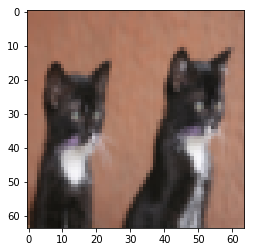

In [19]:
plt.imshow(x_train[0])

In [29]:
print(K.image_data_format()) # difference between Theano and TensorFlow
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], channels, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], channels, img_rows, img_cols)
    input_shape = (channels, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)
    input_shape = (img_rows, img_cols, channels)

channels_last


In [35]:
x_train = x_train.astype('float32') # x_train.dtype
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (209, 64, 64, 3)
209 train samples
50 test samples


In [37]:
print(y_train[:10])

[0 0 1 0 0 0 0 1 0 0]


In [52]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [53]:
print(y_train[:10])

[[1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


In [36]:
print(classes) # binary, 0 is non-cat, 1 is cat

[b'non-cat' b'cat']


In [55]:
# declaring a sequential model format
model = Sequential()

In [56]:
# declare the input layer
model.add(Flatten(input_shape=input_shape))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))

In [57]:
sgd = SGD(lr=0.0)

In [58]:
model.compile(loss=keras.losses.categorical_crossentropy,
              # optimizer=keras.optimizers.Adadelta(),
              optimizer=sgd,
              metrics=['accuracy'])

In [59]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 12288)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              12583936  
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 2050      
Total params: 13,635,586
Trainable params: 13,635,586
Non-trainable params: 0
________________________________________________________________

In [60]:
# learning rate schedule
'''
def my_decay(epoch):
    tau = epochs
    e_0 = 0.01
    e_tau = 0.01 * e_0
    a_k = epoch/tau
    e_k = (1-a_k) * e_0 + a_k * e_tau
    return e_k
'''
def my_decay(iteration):
    tau = max_iter
    e_0 = 0.01
    e_tau = 0.01 * e_0
    a_k = min(iteration/tau, 1)
    e_k = (1-a_k) * e_0 + a_k * e_tau
    return e_k

In [61]:
# create a custom callback by extending the base class keras.callbacks.Callback
# to record loss history and learning rate during the training procedure.
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
       self.losses = []
       self.lr = []
        
    def on_batch_end(self, batch, logs={}):
       self.losses.append(logs.get('loss'))
       self.lr.append(my_decay(len(self.losses)))

In [62]:
loss_history = LossHistory()
lrate = LearningRateScheduler(my_decay)
callbacks_list = [loss_history, lrate]

In [71]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks_list,
          verbose=1, # verbose: Integer. 0, 1, or 2. Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
          validation_data=(x_test, y_test))

Train on 209 samples, validate on 50 samples
Epoch 1/50
209/209 [==============================] - 4s 18ms/step - loss: 0.2558 - acc: 0.8900 - val_loss: 0.9895 - val_acc: 0.5600
Epoch 2/50
209/209 [==============================] - 4s 18ms/step - loss: 0.2376 - acc: 0.8900 - val_loss: 0.6114 - val_acc: 0.7600
Epoch 3/50
209/209 [==============================] - 4s 17ms/step - loss: 0.2305 - acc: 0.8852 - val_loss: 2.0240 - val_acc: 0.4800
Epoch 4/50
209/209 [==============================] - 4s 18ms/step - loss: 0.2501 - acc: 0.8995 - val_loss: 0.7677 - val_acc: 0.8000
Epoch 5/50
209/209 [==============================] - 4s 18ms/step - loss: 0.1903 - acc: 0.9139 - val_loss: 1.2555 - val_acc: 0.5800
Epoch 6/50
209/209 [==============================] - 4s 17ms/step - loss: 0.1350 - acc: 0.9522 - val_loss: 0.7429 - val_acc: 0.7800
Epoch 7/50
209/209 [==============================] - 4s 20ms/step - loss: 0.1372 - acc: 0.9569 - val_loss: 1.9681 - val_acc: 0.6600
Epoch 8/50
209/209 [====

In [72]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.2566493225097657
Test accuracy: 0.7600000047683716


In [73]:
print(len(loss_history.lr))

1350


In [74]:
print(loss_history.losses[:10])
print(loss_history.lr[:10])

[0.106889986, 0.20884332, 0.25909594, 0.23843935, 0.4380064, 0.17420724, 0.22225165, 0.23803595, 0.934217, 0.09231314]
[0.009967, 0.009934, 0.009901, 0.009868000000000002, 0.009835, 0.009802, 0.009769, 0.009736, 0.009703, 0.00967]


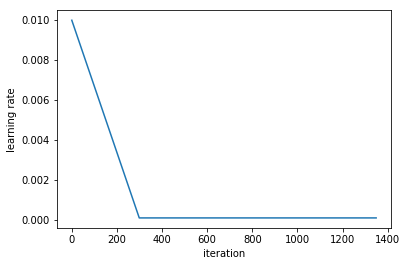

In [75]:
plt.plot(loss_history.lr)
plt.ylabel('learning rate')
plt.xlabel('iteration')
plt.show()